# Bayesian Logistic Regression
---

<div class="alert alert-block alert-info">
    <b>Note:</b> The goal of this notebook is to show you how to work with the <b>bayes-toolbox</b> when you want to utilize a logistic regression model to explain binary outcome data (e.g., flips of a coin, reporting yes or no on a 2AFC task, etc.) The first half of the notebook is an adaptation of Jordi Warmenhoven's PyMC3 port of Chapter 21 of John Kruschke's textbook "Doing Bayesian Data Analysis: A Tutorial with R, JAGS, and Stan" (https://github.com/JWarmenhoven/DBDA-python). The second example is an adaptation of the PyMC developers' port of Chapter 11 of Richard McElreath's textbook "Statistical Rethinking (Second Edition)" (https://github.com/pymc-devs/pymc-resources/tree/main/Rethinking_2). I chose the chimpanzees problem because it is a nice example of how effective modeling individual intercepts can be (see textbook for much more detail). In the case of the Kruschke example, please note that the code has been updated to make use of PyMC4. This notebook does not (yet) include all of the examples from the originals. </div>

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
import pytensor
import pytensor.tensor as pt
from scipy.special import expit as logistic

# Import bayes-toolbox
import bayes_toolbox.glm as bg

from IPython.display import Image

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v4.3.0


In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.95

### Kruschke: Ch 21

In [3]:
df = pd.read_csv("data/HtWtData110.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   male    110 non-null    int64  
 1   height  110 non-null    float64
 2   weight  110 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.7 KB


In [4]:
X = df[["weight", "height"]]
y = df["male"]

zX, mu_X, sigma_X = bg.standardize(X)

### Kruschke-style graphical model 

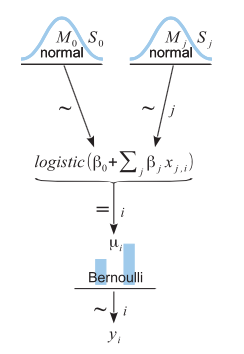

In [5]:
Image("images/fig21_2.png")

#### Predicting gender from weight and height

In [6]:
# Fit your Bayesian model using bg
model, idata = bg.bayesian_logreg_cat_predictors(X, y, n_draws=3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [zbeta0, zbetaj]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 20 seconds.


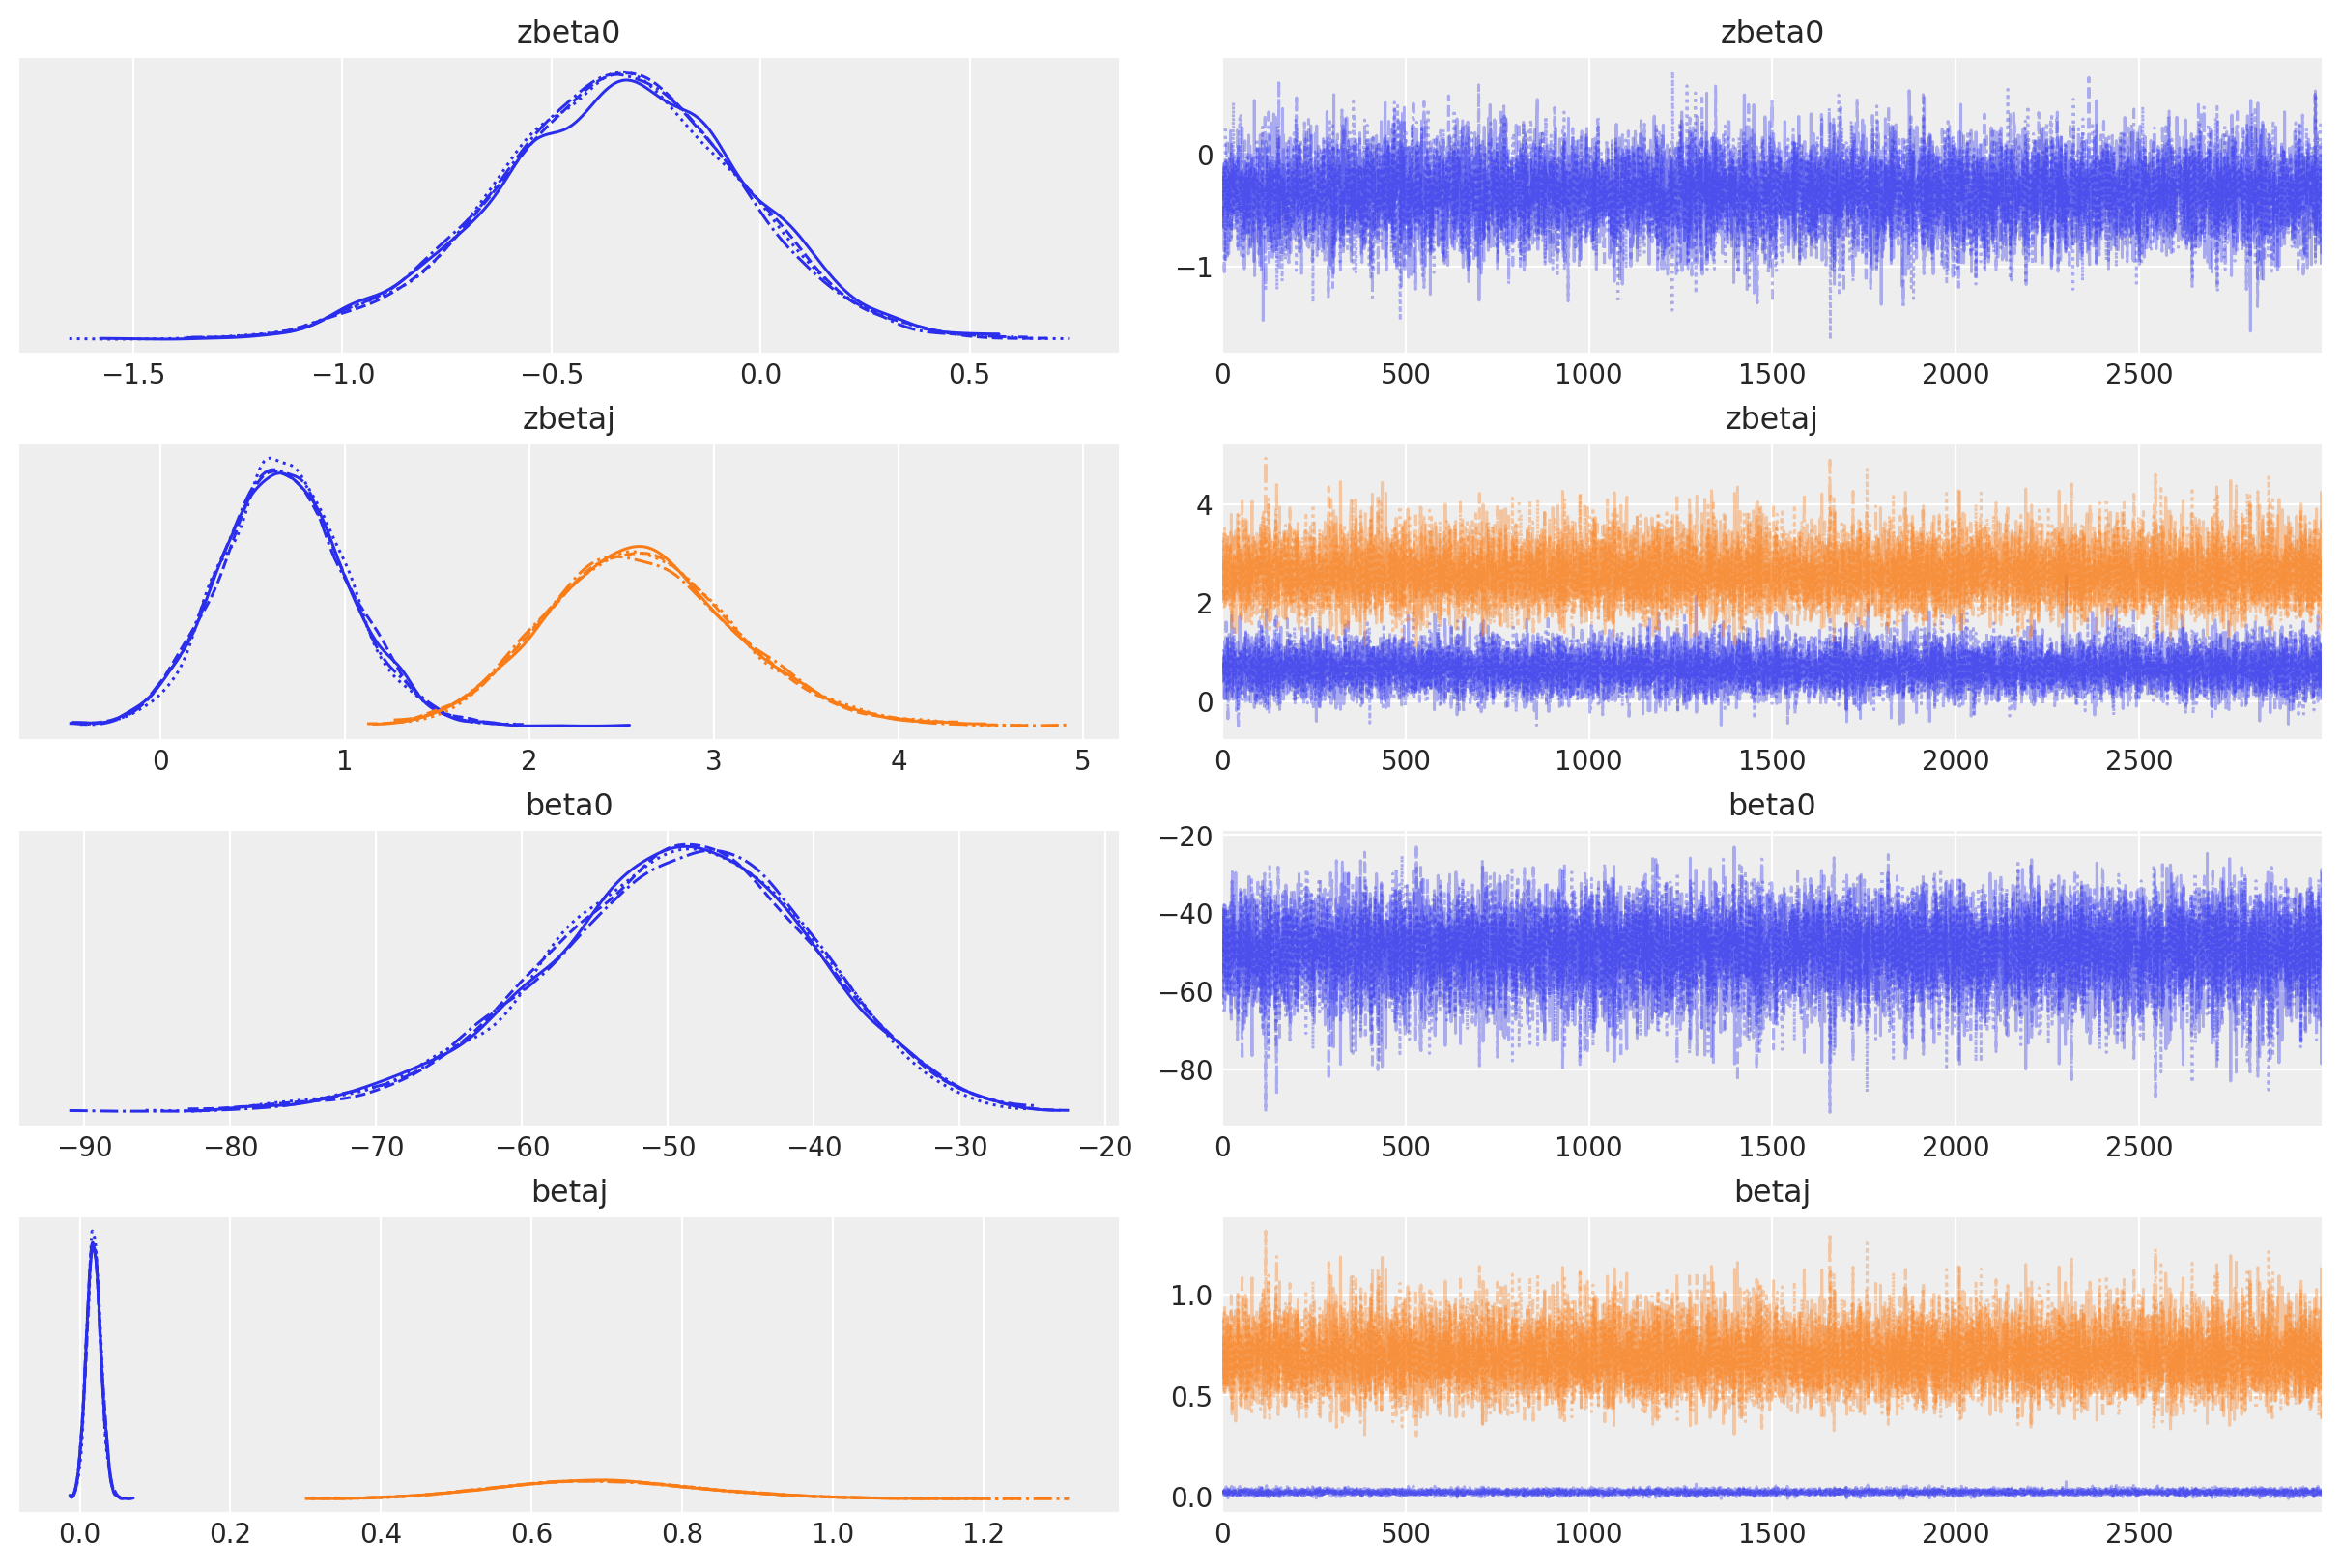

In [7]:
az.plot_trace(idata);

In [8]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

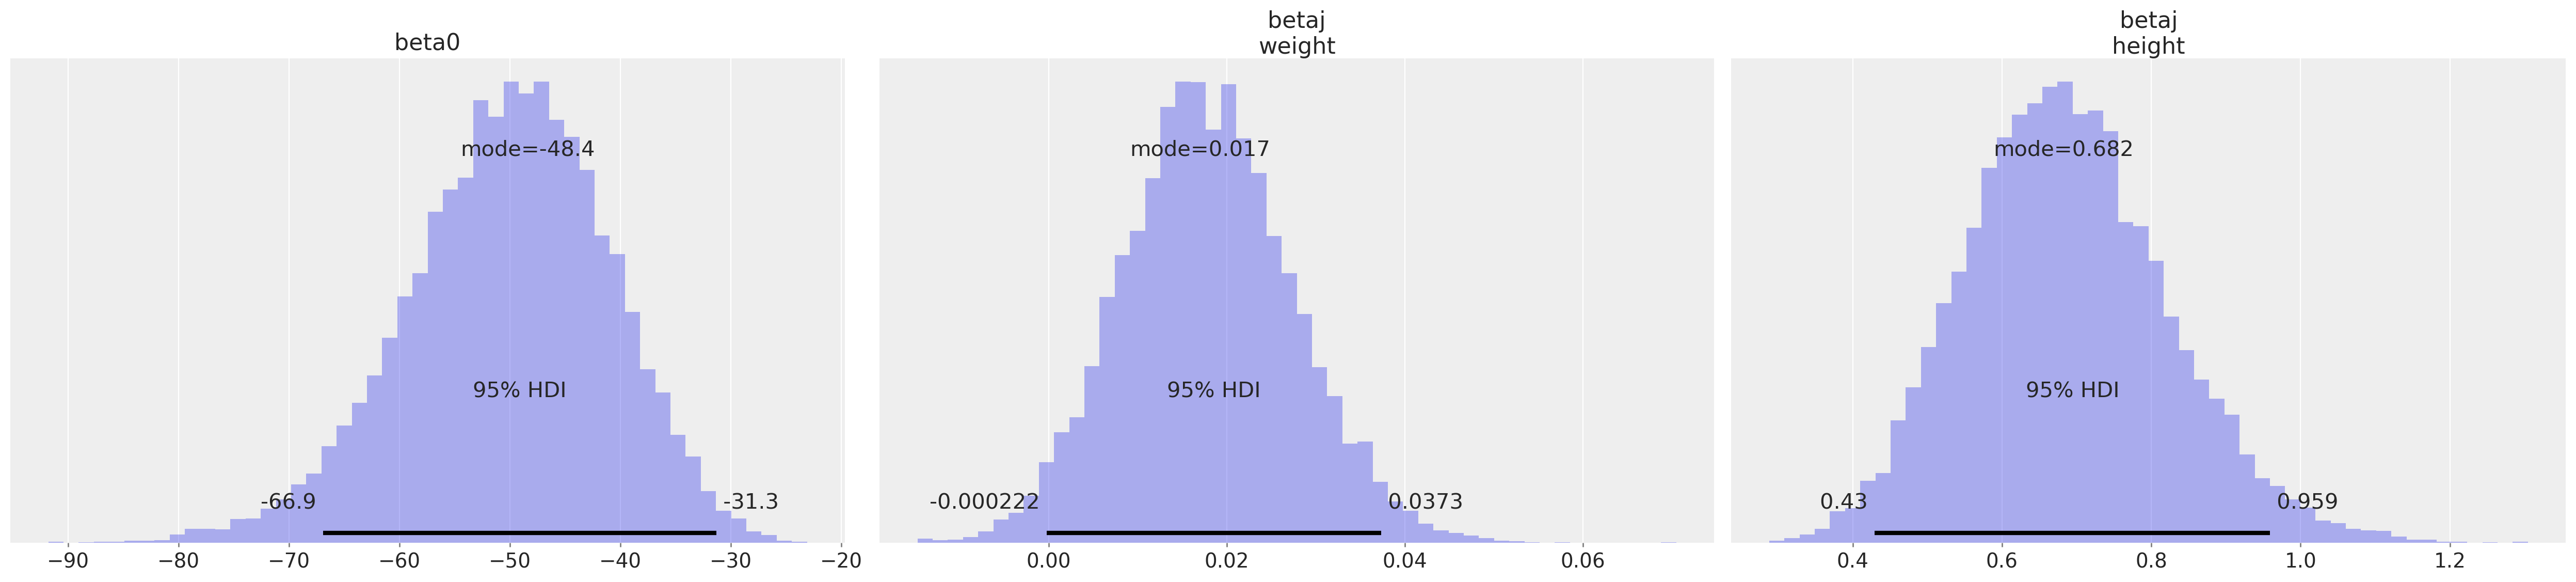

In [9]:
az.plot_posterior(
    idata,
    var_names=["beta0", "betaj"],
    kind="hist",
    bins=50,
    point_estimate="mode",
    round_to=3,
    coords={"predictors": ["weight", "height"]},
);

### Code 11.1

The next example is from Ch. 11 of Statistical Rethinking (2nd ed.), in which the model includes a separate intercept parameter for each participant as well as a nominal predictor.

In [10]:
# These data are from Statistical Rethinking 2
d = pd.read_csv("Data/chimpanzees.csv", sep=";")
# we change "actor" to zero-index
d.actor = d.actor - 1
d

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,0,NaN,0,1,2,0,1,0
1,0,NaN,0,1,4,0,0,1
2,0,NaN,0,1,6,1,0,0
3,0,NaN,0,1,8,0,1,0
4,0,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,6,4.0,1,6,64,1,1,1
500,6,6.0,1,6,66,1,1,1
501,6,3.0,1,6,68,0,0,1
502,6,7.0,1,6,70,0,0,1


#### Code 11.2

In [11]:
d["treatment"] = d.prosoc_left + 2 * d.condition
d[["actor", "prosoc_left", "condition", "treatment"]]

,actor,prosoc_left,condition,treatment
0,0,0,0,0
1,0,0,0,0
2,0,1,0,1
3,0,0,0,0
4,0,1,0,1
...,...,...,...,...
499,6,1,1,3
500,6,1,1,3
501,6,0,1,2
502,6,0,1,2


#### Code 11.3

In [12]:
d.groupby("treatment").first()[["prosoc_left", "condition"]]

,prosoc_left,condition
treatment,,
0,0,0
1,1,0
2,0,1
3,1,1


In [13]:
subj = d.actor
X = d.treatment
y = d.pulled_left

# Fit your Bayesian model using bayes-toolbox
model2, idata2 = bg.bayesian_logreg_subj_intercepts(subj, X, y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


Below, we run a prior predictive check. This is a technique that is strongly advocated by Richard McElreath (and others) as it is a good sanity check to see what sort of parameter values your model gives credibility to prior to incorporating the observed data. In the PyMC notebook, they compare the below prior to one defined as $a \sim Normal(0, 10)$ to make the point that if your prior is too diffuse on the log-odds scale, when converted to probability space it lumps most of the probability near 0 and 1.

Sampling: [a, b, likelihood]


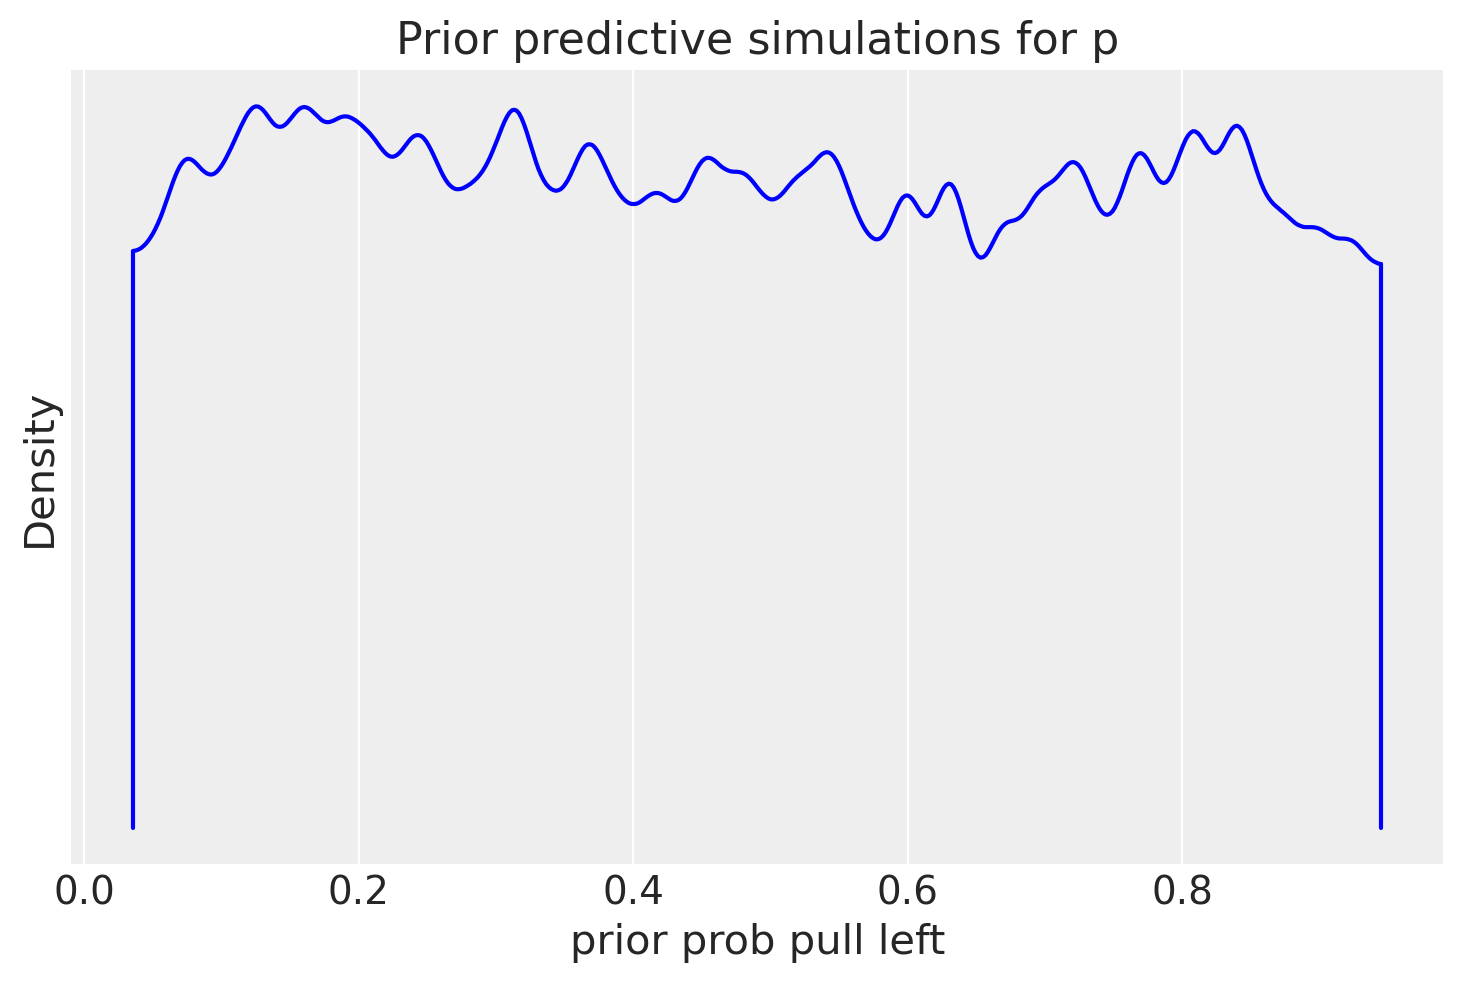

In [14]:
# Use your model to sample from the prior
with model2:
    prior2 = pm.sample_prior_predictive()

ax = az.plot_density(
    prior2["prior"],
    data_labels=["a ~ Normal(0, 1.5)"],
    group="prior",
    combine_dims={"p_dim_0"},
    colors=["b"],
    var_names=["p"],
    point_estimate=None,
)[0]
ax[0].set_xlabel("prior prob pull left")
ax[0].set_ylabel("Density")
ax[0].set_title("Prior predictive simulations for p");

In [15]:
az.summary(idata2, var_names=["a", "b"], round_to=2)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.46,0.33,-1.11,0.18,0.01,0.01,1730.63,2665.24,1.0
a[1],3.88,0.76,2.47,5.41,0.01,0.01,4067.69,2582.71,1.0
a[2],-0.76,0.34,-1.40,-0.07,0.01,0.01,1590.66,2479.55,1.0
a[3],-0.76,0.34,-1.42,-0.10,0.01,0.01,1732.15,2548.23,1.0
a[4],-0.46,0.33,-1.08,0.21,0.01,0.01,1662.25,2098.19,1.0
a[5],0.47,0.33,-0.14,1.12,0.01,0.01,1573.56,2443.67,1.0
a[6],1.94,0.42,1.13,2.76,0.01,0.01,2102.52,2705.45,1.0
b[0],-0.03,0.29,-0.61,0.51,0.01,0.01,1462.33,1858.20,1.0
b[1],0.50,0.29,-0.07,1.05,0.01,0.01,1466.00,2671.95,1.0
b[2],-0.37,0.29,-0.91,0.21,0.01,0.01,1512.51,2382.03,1.0


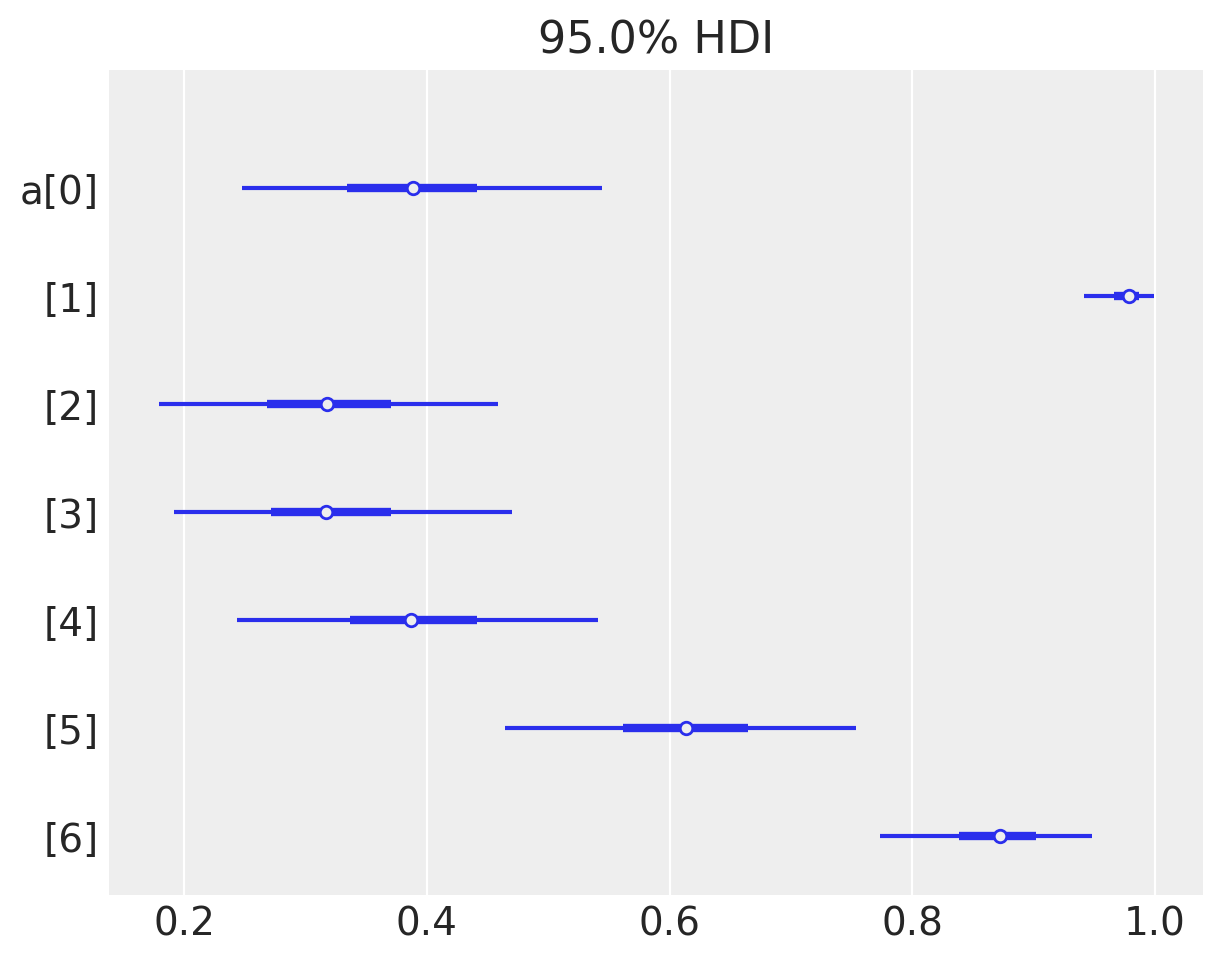

In [16]:
# Plotting effect of intercept parameters in terms of probability as opposed to log-odds
az.plot_forest(idata2, var_names=["a"], transform=logistic, combined=True);

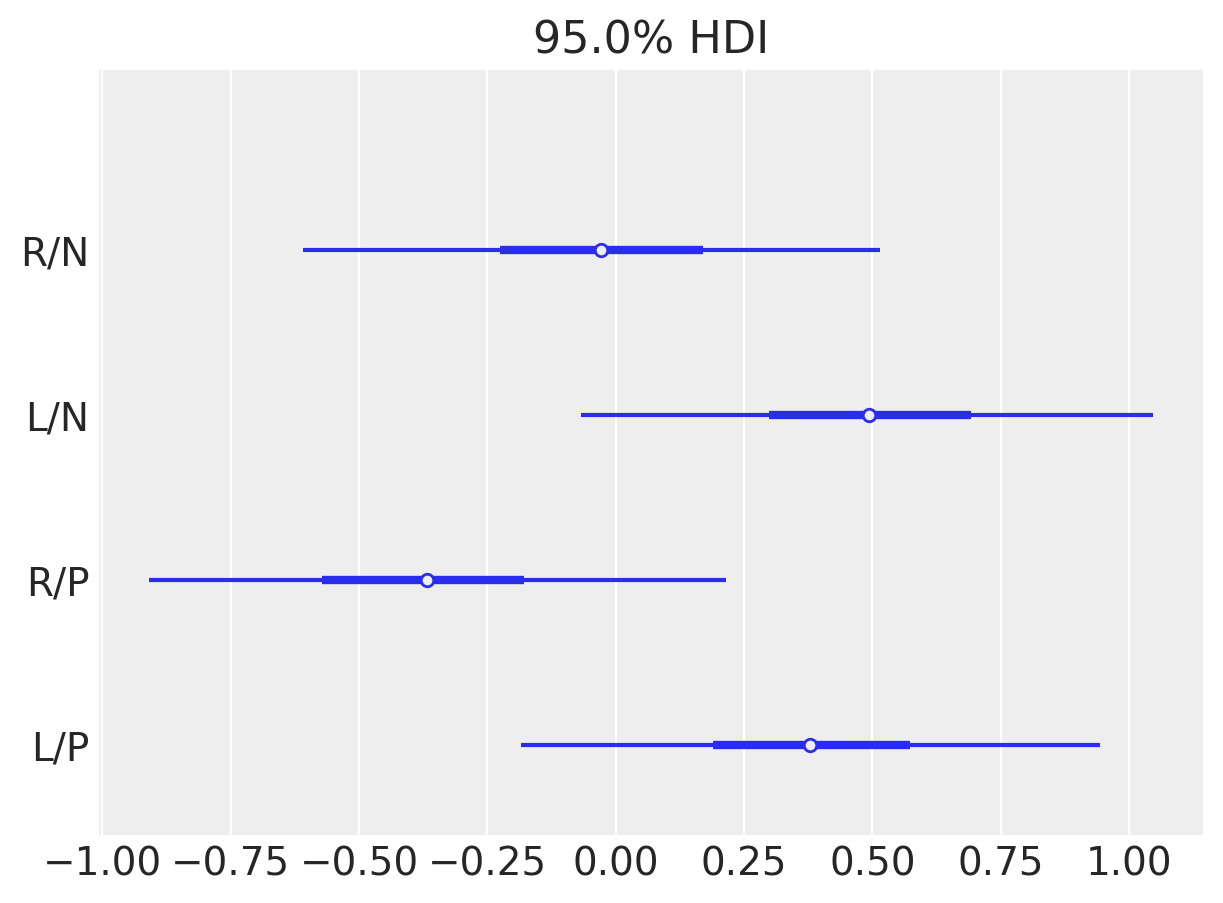

In [17]:
ax = az.plot_forest(idata2, var_names=["b"], combined=True)
ax[0].set_yticklabels(["L/P", "R/P", "L/N", "R/N"]);